In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os 
import tensorflow as tf 
import keras.backend.tensorflow_backend as KTF #进行配置，每个GPU使用60%上限现存 
os.environ["CUDA_VISIBLE_DEVICES"]="0,1" # 使用编号为1，2号的GPU 
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 1 # 每个GPU现存上届控制在100%以内 
session = tf.Session(config=config) # 设置session KTF.set_session(session )

Using TensorFlow backend.


In [3]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_lowercase
print(characters)

width, height, n_len, n_class = 180, 60, 4, len(characters)

0123456789abcdefghijklmnopqrstuvwxyz


In [4]:
import process
from PIL import Image

train_file_path = 'D:\BaiduYunDownload\jwxt_captcha_data/train'
train_image_path, train_image_label = process.get_data(train_file_path)
print(train_image_label[0:10])

test_file_path = 'D:\BaiduYunDownload\jwxt_captcha_data/test'
test_image_path, test_image_label = process.get_data(test_file_path)
print(test_image_label[0:10])
print(test_image_path[0])

x = process.getImage(test_image_path[0])
print(x.shape)

['2223', '2224', '2226', '222a', '222e', '222g', '222h', '222j', '222k', '222m']
['226p', '226w', '22b2', '22b4', '22mb', '22w3', '232f', '237a', '23md', '23nf']
D:\BaiduYunDownload\jwxt_captcha_data/test\226p.jpg
(60, 180, 3)


In [5]:
import process
import random
from PIL import Image
def get_image(path):
    return Image.open(path, 'r')

def gen(path, label, batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
#     print(len(path))
#     print(len(label))
    while True:
        cc = list(zip(path, label))
        random.shuffle(cc)
        path[:], label[:] = zip(*cc)
        count = 0
        for i in range(len(label)):
            X[count] = Image.open(path[i], 'r')
            random_str = label[i]
            for j, ch in enumerate(random_str):
                y[j][count, :] = 0
                y[j][count, characters.find(ch)] = 1
            
            count += 1
            if count ==batch_size:
#                 print(X.shape)
                yield X, y
                count = 0


(1, 60, 180, 3)
(4, 1, 36)
(1, 36)


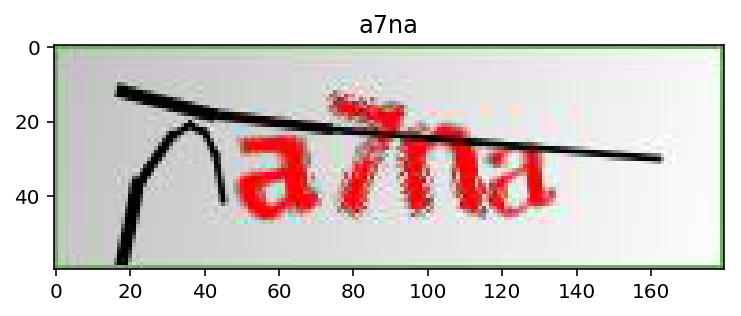

In [6]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next( gen(test_image_path, test_image_label,1))
print(X.shape)
print(np.array(y).shape)
print(y[0].shape)
plt.imshow(X[0])
plt.title(decode(y))

In [7]:
from keras.models import *
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(3):
    x = Convolution2D(32*2**i, 3, 3)(x)
    x = Activation('relu')(x)
    x = Convolution2D(32*2**i, 3, 3)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

x = Convolution2D(32*2**i, 2, 2)(x)
x = Activation('relu')(x)
x = Convolution2D(32*2**i, 2, 2)(x)
x = Activation('relu')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.5)(x)
x = [
    Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(input=input_tensor, output=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'],
             )

In [8]:
# model.load_weights('captcha.h5')

In [ ]:
model.fit_generator(gen(train_image_path, train_image_label, 128), samples_per_epoch=84017//128, nb_epoch=1,
                    validation_data=gen(test_image_path, test_image_label, 32), nb_val_samples=256)

def evaluate(model, batch_num=40):
    batch_acc = 0
#     generator = gen(test_image_path, test_image_label, 32)
    for i in range(batch_num):
        X, y = next(gen(test_image_path, test_image_label, 32))
        y_pred = model.predict(X)
        batch_acc += np.mean(list(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T)))
    return batch_acc / batch_num

acc = evaluate(model)
print(acc)
model.save('captcha1.h5')

84014Epoch 1/1
84014



In [8]:
model.load_weights('captcha1.h5')

(-0.5, 179.5, 59.5, -0.5)

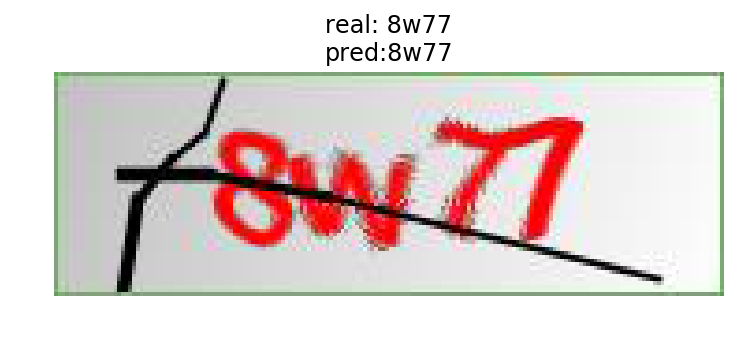

In [9]:
X, y = next(gen(test_image_path, test_image_label,1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

In [8]:
model.load_weights('captcha1.h5')

model.fit_generator(gen(train_image_path, train_image_label, 64), samples_per_epoch=84017//128, nb_epoch=1,
                    validation_data=gen(test_image_path, test_image_label, 32), nb_val_samples=256,)

def evaluate(model, batch_num=40):
    batch_acc = 0
#     generator = gen(test_image_path, test_image_label, 32)
    for i in range(batch_num):
        X, y = next(gen(test_image_path, test_image_label, 32))
        y_pred = model.predict(X)
        batch_acc += np.mean(list(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T)))
    return batch_acc / batch_num

acc = evaluate(model)
print(acc)
model.save('captcha2.h5')

Epoch 1/1
656/656 [==============================] - 322s 490ms/step - loss: 0.8670 - c1_loss: 0.4090 - c2_loss: 0.0254 - c3_loss: 0.0240 - c4_loss: 0.4085 - c1_acc: 0.9555 - c2_acc: 0.9963 - c3_acc: 0.9967 - c4_acc: 0.9554 - val_loss: 1.9108 - val_c1_loss: 0.2464 - val_c2_loss: 0.4236 - val_c3_loss: 0.8797 - val_c4_loss: 0.3612 - val_c1_acc: 0.9641 - val_c2_acc: 0.8834 - val_c3_acc: 0.7596 - val_c4_acc: 0.9092
0.59375


(-0.5, 179.5, 59.5, -0.5)

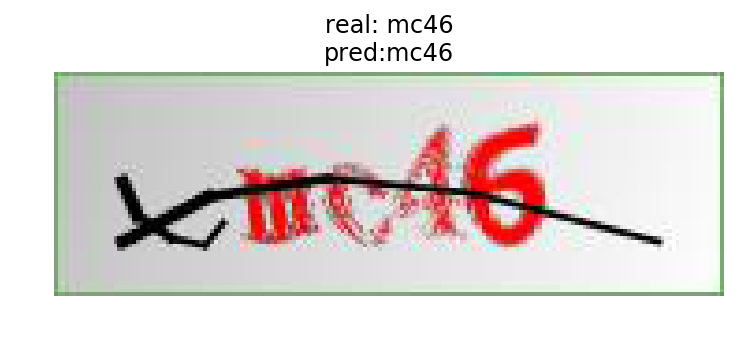

In [48]:
X, y = next(gen(test_image_path, test_image_label,1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')